In [1]:
# Ankle Alignment Label Exploration
# This notebook analyzes the consensus labels from multiple labelers

import pandas as pd
import numpy as np
import json
import re
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter

# Set style for visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")


## 1. Load Data

Load the image paths from the consensus text file (ground truth) and all labeler annotations.
Only images in the text file are considered valid.


In [2]:
# Define paths
CONSENSUS_PATH = Path("../anklealign/consensus")
IMAGE_LIST_FILE = CONSENSUS_PATH / "anklealign-consensus.txt"

# Load valid image paths from the text file (this is the ground truth)
with open(IMAGE_LIST_FILE, 'r') as f:
    image_paths = [line.strip() for line in f.readlines()]

# Create set of valid image names (filenames only)
valid_image_names = set()
image_name_to_path = {}
for path in image_paths:
    name = Path(path).name
    valid_image_names.add(name)
    image_name_to_path[name] = path

print(f"Total valid images in consensus set: {len(valid_image_names)}")
print(f"\nFirst 10 valid image names:")
for name in sorted(valid_image_names)[:10]:
    print(f"  {name}")


Total valid images in consensus set: 53

First 10 valid image names:
  sajat_resztvevo01_01.jpg
  sajat_resztvevo01_02.jpg
  sajat_resztvevo01_03.jpg
  sajat_resztvevo01_04.jpg
  sajat_resztvevo02_01.jpg
  sajat_resztvevo02_02.jpg
  sajat_resztvevo02_03.jpg
  sajat_resztvevo02_04.jpg
  sajat_resztvevo03_01.jpg
  sajat_resztvevo03_02.jpg


In [3]:
# Load all labeler JSON files
json_files = [f for f in CONSENSUS_PATH.glob("*.json")]
labeler_ids = [f.stem for f in json_files]

print(f"Found {len(json_files)} labeler files:")
for f in sorted(json_files):
    print(f"  {f.stem}")


Found 21 labeler files:
  b8v41y
  C6037J
  D0V869
  D6AE9F
  DN04PZ
  DPMC6W
  ECSGGY
  FGWUFP
  FO6K58
  GI9Y8B
  GK1XQ4
  h51b9j
  ITWQ3V
  KRCH5Q
  NC1O2T
  NX9GA4
  ODZF0M
  OJHGS8
  XV0M8Z
  YLEX88
  YY0APN


In [4]:
def normalize_image_name(file_upload_path, valid_names, all_labeler_ids):
    """
    Normalize image name from Label Studio file_upload path.
    Handles various naming issues:
    1. UUID prefix from Label Studio: "uuid-original_name.jpg"
    2. Labeler code prefix: "LABELER_original_name.jpg"
    3. Combinations of both
    
    Returns:
        Normalized image name if it matches a valid name, None otherwise
    """
    # Get just the filename
    filename = Path(file_upload_path).name
    
    # Step 1: Remove UUID prefix (format: 8 hex chars followed by hyphen)
    uuid_pattern = r'^[a-f0-9]{8}-(.+)$'
    match = re.match(uuid_pattern, filename, re.IGNORECASE)
    if match:
        filename = match.group(1)
    
    # Check if already valid
    if filename in valid_names:
        return filename
    
    # Step 2: Try removing labeler code prefix (LABELER_filename)
    for lid in all_labeler_ids:
        prefix = f"{lid}_"
        if filename.lower().startswith(prefix.lower()):
            potential_name = filename[len(prefix):]
            if potential_name in valid_names:
                return potential_name
            # Try case-insensitive match
            for valid_name in valid_names:
                if potential_name.lower() == valid_name.lower():
                    return valid_name

    # step 2.5: Try removing labeler code postfix (original_name_LABELER.jpg)
    for lid in all_labeler_ids:
        prefix = f"_{lid}.jpg"
        if filename.lower().endswith(prefix.lower()):
            potential_name = filename[:-len(prefix)] + ".jpg"
            if potential_name in valid_names:
                return potential_name
    
    # Step 3: Try case-insensitive match directly
    for valid_name in valid_names:
        if filename.lower() == valid_name.lower():
            return valid_name
    
    # Step 4: Fuzzy match - check if filename contains a valid name
    for valid_name in valid_names:
        if valid_name.lower() in filename.lower():
            return valid_name
    
    # Could not match to a valid image
    return None

# Test the function
print("Testing normalize_image_name:")
test_cases = [
    "3233e03a-sajat_reszvevo01_01.jpg",
    "D6AE9F_sajat_reszvevo01_01.jpg", 
    "3233e03a-D6AE9F_sajat_reszvevo01_01.jpg",
    "sajat_reszvevo01_01.jpg",
    "426c232b-sajat_reszvevo03_04_D6AE9F.jpg",
    "sajat_reszvevo01_01_D6AE9F.jpg"
]
for test in test_cases:
    result = normalize_image_name(test, valid_image_names, labeler_ids)
    status = "✓" if result else "✗"
    print(f"  {status} {test} -> {result}")


Testing normalize_image_name:
  ✓ 3233e03a-sajat_reszvevo01_01.jpg -> sajat_reszvevo01_01.jpg
  ✓ D6AE9F_sajat_reszvevo01_01.jpg -> sajat_reszvevo01_01.jpg
  ✓ 3233e03a-D6AE9F_sajat_reszvevo01_01.jpg -> sajat_reszvevo01_01.jpg
  ✓ sajat_reszvevo01_01.jpg -> sajat_reszvevo01_01.jpg
  ✓ 426c232b-sajat_reszvevo03_04_D6AE9F.jpg -> sajat_reszvevo03_04.jpg
  ✓ sajat_reszvevo01_01_D6AE9F.jpg -> sajat_reszvevo01_01.jpg


In [5]:
def parse_labelstudio_json(json_path, valid_names, all_labeler_ids):
    """
    Parse Label Studio export JSON and extract image-label mappings.
    Only includes images that are in the valid_names set.
    
    Returns:
        dict: {normalized_image_name: label} mapping
        list: unmatched image names (for debugging)
    """
    with open(json_path, 'r', encoding='utf-8') as f:
        try:
            data = json.load(f)
        except json.JSONDecodeError:
            print(f"Error decoding JSON file: {json_path}")
            return {}, []
    
    labels = {}
    unmatched = []
    
    for task in data:
        file_upload = task.get('file_upload', '')
        
        # Normalize and validate image name
        image_name = normalize_image_name(file_upload, valid_names, all_labeler_ids)
        
        if image_name is None:
            unmatched.append(file_upload)
            continue
        
        # Extract label from annotations
        annotations = task.get('annotations', [])
        if annotations:
            annotation = annotations[0]
            results = annotation.get('result', [])
            
            if results:
                value = results[0].get('value', {})
                choices = value.get('choices', [])
                if choices:
                    labels[image_name] = choices[0]
    
    return labels, unmatched

# Load all labeler data with validation
labeler_data = {}
all_unmatched = {}

for json_file in json_files:
    labeler_id = json_file.stem
    labels, unmatched = parse_labelstudio_json(json_file, valid_image_names, labeler_ids)
    # check if empty
    if not labels:
        print(f"No labels found for {labeler_id}")
        continue
    labeler_data[labeler_id] = labels
    if unmatched:
        all_unmatched[labeler_id] = unmatched

print("Labeler annotation counts (only valid images):")
for labeler_id, labels in sorted(labeler_data.items()):
    print(f"  {labeler_id}: {len(labels)} annotations")


Error decoding JSON file: ..\anklealign\consensus\DPMC6W.json
No labels found for DPMC6W
No labels found for GI9Y8B
Error decoding JSON file: ..\anklealign\consensus\ITWQ3V.json
No labels found for ITWQ3V
Labeler annotation counts (only valid images):
  C6037J: 53 annotations
  D0V869: 53 annotations
  D6AE9F: 52 annotations
  DN04PZ: 53 annotations
  ECSGGY: 30 annotations
  FGWUFP: 53 annotations
  FO6K58: 52 annotations
  GK1XQ4: 53 annotations
  KRCH5Q: 8 annotations
  NC1O2T: 53 annotations
  NX9GA4: 53 annotations
  ODZF0M: 48 annotations
  OJHGS8: 53 annotations
  XV0M8Z: 53 annotations
  YLEX88: 53 annotations
  YY0APN: 52 annotations
  b8v41y: 53 annotations
  h51b9j: 52 annotations


In [6]:
# Report on unmatched/extra images (excluded from analysis)
if all_unmatched:
    print("=" * 70)
    print("UNMATCHED IMAGES (excluded from analysis)")
    print("=" * 70)
    total_unmatched = sum(len(v) for v in all_unmatched.values())
    print(f"\nTotal unmatched: {total_unmatched} images across {len(all_unmatched)} labelers\n")
    
    for labeler_id, unmatched in sorted(all_unmatched.items()):
        print(f"{labeler_id} ({len(unmatched)} extra/malformed images):")
        for img in unmatched[:3]:  # Show first 3
            print(f"  - {img}")
        if len(unmatched) > 3:
            print(f"  ... and {len(unmatched) - 3} more")
        print()
else:
    print("All images matched successfully!")


UNMATCHED IMAGES (excluded from analysis)

Total unmatched: 56 images across 4 labelers

D0V869 (8 extra/malformed images):
  - c72093d7-sajat_reszvevo01_01_D6AE9F_D6AE9F.jpg
  - 04099bce-sajat_reszvevo01_02_D6AE9F_D6AE9F.jpg
  - 6c76edec-sajat_reszvevo01_03_D6AE9F_D6AE9F.jpg
  ... and 5 more

DN04PZ (22 extra/malformed images):
  - 1ebc3adc-internet_dreamstime_12.jpg
  - 533733dd-internet_freepik_07.jpg
  - 53ffff93-internet_freepik_08.jpg
  ... and 19 more

NX9GA4 (4 extra/malformed images):
  - ee5a9d01-sajat_reszvevo01_01_2.jpg
  - 239dbcc2-sajat_reszvevo01_02_2.jpg
  - ef3c0285-sajat_reszvevo01_03_2.jpg
  ... and 1 more

YY0APN (22 extra/malformed images):
  - 35e3b53a-internet_dreamstime_12.jpg
  - 55fbdffe-internet_freepik_07.jpg
  - 602fd69f-internet_freepik_08.jpg
  ... and 19 more



## 2. Create Combined Labels DataFrame

Build a comprehensive DataFrame with labels only for valid images from the consensus list.


In [7]:
# Create DataFrame with ONLY valid images as rows
labeler_ids_sorted = sorted(labeler_data.keys())

df_labels = pd.DataFrame(index=sorted(valid_image_names), columns=labeler_ids_sorted)
df_labels.index.name = 'image'

for labeler_id, labels in labeler_data.items():
    for image_name, label in labels.items():
        if image_name in valid_image_names:
            df_labels.loc[image_name, labeler_id] = label

print(f"Labels DataFrame shape: {df_labels.shape}")
print(f"  - {len(df_labels)} images (from consensus list)")
print(f"  - {len(df_labels.columns)} labelers")
df_labels.head(10)


Labels DataFrame shape: (53, 18)
  - 53 images (from consensus list)
  - 18 labelers


,C6037J,D0V869,D6AE9F,DN04PZ,ECSGGY,FGWUFP,FO6K58,GK1XQ4,KRCH5Q,NC1O2T,NX9GA4,ODZF0M,OJHGS8,XV0M8Z,YLEX88,YY0APN,b8v41y,h51b9j
image,,,,,,,,,,,,,,,,,,
sajat_resztvevo01_01.jpg,1_Pronacio,2_Neutralis,1_Pronacio,1_Pronacio,NaN,3_Szupinacio,1_Pronacio,1_Pronacio,NaN,1_Pronacio,2_Neutralis,1_Pronacio,1_Pronacio,2_Neutralis,1_Pronacio,2_Neutralis,1_Pronacio,1_Pronacio
sajat_resztvevo01_02.jpg,1_Pronacio,2_Neutralis,1_Pronacio,1_Pronacio,NaN,3_Szupinacio,1_Pronacio,1_Pronacio,NaN,1_Pronacio,2_Neutralis,1_Pronacio,1_Pronacio,1_Pronacio,1_Pronacio,2_Neutralis,1_Pronacio,1_Pronacio
sajat_resztvevo01_03.jpg,1_Pronacio,2_Neutralis,1_Pronacio,1_Pronacio,NaN,3_Szupinacio,1_Pronacio,1_Pronacio,NaN,1_Pronacio,2_Neutralis,1_Pronacio,1_Pronacio,1_Pronacio,1_Pronacio,2_Neutralis,1_Pronacio,1_Pronacio
sajat_resztvevo01_04.jpg,1_Pronacio,2_Neutralis,1_Pronacio,1_Pronacio,NaN,3_Szupinacio,1_Pronacio,1_Pronacio,NaN,1_Pronacio,2_Neutralis,1_Pronacio,1_Pronacio,1_Pronacio,1_Pronacio,2_Neutralis,1_Pronacio,1_Pronacio
sajat_resztvevo02_01.jpg,2_Neutralis,1_Pronáló,2_Neutralis,2_Neutralis,NaN,1_Pronacio,2_Neutralis,2_Neutralis,NaN,2_Neutralis,2_Neutralis,2_Neutralis,1_Pronacio,2_Neutralis,2_Neutralis,2_Neutralis,1_Pronacio,2_Neutralis
sajat_resztvevo02_02.jpg,2_Neutralis,2_Neutralis,1_Pronacio,2_Neutralis,NaN,2_Neutralis,2_Neutralis,1_Pronacio,NaN,2_Neutralis,1_Pronacio,2_Neutralis,1_Pronacio,2_Neutralis,2_Neutralis,2_Neutralis,1_Pronacio,2_Neutralis
sajat_resztvevo02_03.jpg,2_Neutralis,1_Pronáló,2_Neutralis,1_Pronacio,NaN,2_Neutralis,2_Neutralis,1_Pronacio,NaN,2_Neutralis,1_Pronacio,2_Neutralis,1_Pronacio,2_Neutralis,2_Neutralis,2_Neutralis,1_Pronacio,2_Neutralis
sajat_resztvevo02_04.jpg,2_Neutralis,2_Neutralis,2_Neutralis,2_Neutralis,NaN,2_Neutralis,2_Neutralis,2_Neutralis,NaN,2_Neutralis,2_Neutralis,2_Neutralis,1_Pronacio,2_Neutralis,2_Neutralis,2_Neutralis,2_Neutralis,2_Neutralis
sajat_resztvevo03_01.jpg,2_Neutralis,2_Neutralis,2_Neutralis,2_Neutralis,NaN,2_Neutralis,2_Neutralis,2_Neutralis,NaN,2_Neutralis,2_Neutralis,2_Neutralis,1_Pronacio,3_Szupinacio,2_Neutralis,2_Neutralis,2_Neutralis,2_Neutralis


In [8]:
# Define label categories and their display names
LABEL_MAP = {
    '1_Pronacio': 'Pronation',
    '1_Pronáló': 'Pronation',
    '2_Neutralis': 'Neutral',
    '3_Szupinacio': 'Supination',
    '3_Szupináló': 'Supination'
}

def simplify_label(label):
    if pd.isna(label):
        return None
    return LABEL_MAP.get(label, label)

df_labels_simple = df_labels.apply(lambda col: col.map(lambda x: simplify_label(x)))
df_labels_simple.head()


,C6037J,D0V869,D6AE9F,DN04PZ,ECSGGY,FGWUFP,FO6K58,GK1XQ4,KRCH5Q,NC1O2T,NX9GA4,ODZF0M,OJHGS8,XV0M8Z,YLEX88,YY0APN,b8v41y,h51b9j
image,,,,,,,,,,,,,,,,,,
sajat_resztvevo01_01.jpg,Pronation,Neutral,Pronation,Pronation,None,Supination,Pronation,Pronation,None,Pronation,Neutral,Pronation,Pronation,Neutral,Pronation,Neutral,Pronation,Pronation
sajat_resztvevo01_02.jpg,Pronation,Neutral,Pronation,Pronation,None,Supination,Pronation,Pronation,None,Pronation,Neutral,Pronation,Pronation,Pronation,Pronation,Neutral,Pronation,Pronation
sajat_resztvevo01_03.jpg,Pronation,Neutral,Pronation,Pronation,None,Supination,Pronation,Pronation,None,Pronation,Neutral,Pronation,Pronation,Pronation,Pronation,Neutral,Pronation,Pronation
sajat_resztvevo01_04.jpg,Pronation,Neutral,Pronation,Pronation,None,Supination,Pronation,Pronation,None,Pronation,Neutral,Pronation,Pronation,Pronation,Pronation,Neutral,Pronation,Pronation
sajat_resztvevo02_01.jpg,Neutral,Pronation,Neutral,Neutral,None,Pronation,Neutral,Neutral,None,Neutral,Neutral,Neutral,Pronation,Neutral,Neutral,Neutral,Pronation,Neutral


In [9]:
# list all unique fields in the DataFrame
df_labels_simple.apply(pd.Series.unique)

C6037J          [Pronation, Neutral, Supination]
D0V869          [Neutral, Pronation, Supination]
D6AE9F    [Pronation, Neutral, None, Supination]
DN04PZ                      [Pronation, Neutral]
ECSGGY    [None, Neutral, Pronation, Supination]
FGWUFP          [Supination, Pronation, Neutral]
FO6K58    [Pronation, Neutral, Supination, None]
GK1XQ4          [Pronation, Neutral, Supination]
KRCH5Q    [None, Neutral, Pronation, Supination]
NC1O2T                      [Pronation, Neutral]
NX9GA4          [Neutral, Pronation, Supination]
ODZF0M    [Pronation, Neutral, None, Supination]
OJHGS8          [Pronation, Neutral, Supination]
XV0M8Z          [Neutral, Pronation, Supination]
YLEX88          [Pronation, Neutral, Supination]
YY0APN    [Neutral, Pronation, None, Supination]
b8v41y          [Pronation, Neutral, Supination]
h51b9j                [Pronation, Neutral, None]
dtype: object

## 3. Label Distribution Analysis


Overall Label Distribution:
Neutral       582
Pronation     205
Supination     90
Name: count, dtype: int64

Total annotations: 877


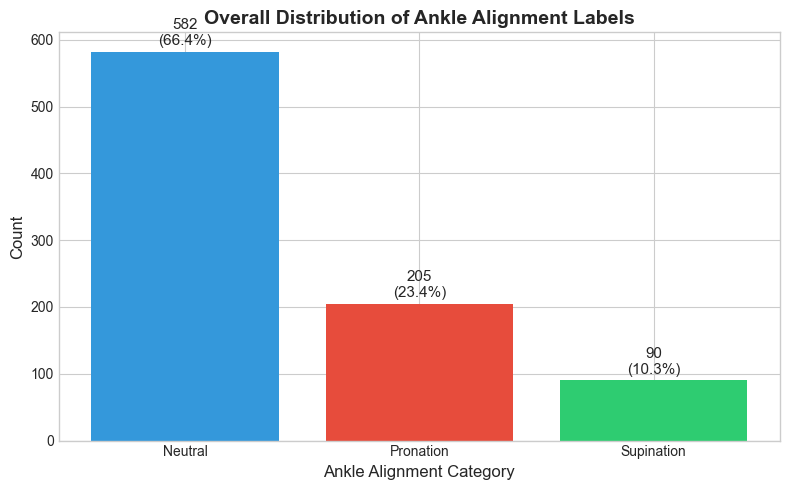

In [10]:
# Overall label distribution across all annotations
all_labels = df_labels_simple.values.flatten()
all_labels = [l for l in all_labels if l is not None]

label_counts = pd.Series(all_labels).value_counts()
print("Overall Label Distribution:")
print(label_counts)
print(f"\nTotal annotations: {len(all_labels)}")

# Plot overall distribution
fig, ax = plt.subplots(figsize=(8, 5))
colors = {'Pronation': '#e74c3c', 'Neutral': '#3498db', 'Supination': '#2ecc71'}
bars = ax.bar(label_counts.index, label_counts.values, 
              color=[colors.get(x, '#95a5a6') for x in label_counts.index])
ax.set_xlabel('Ankle Alignment Category', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Overall Distribution of Ankle Alignment Labels', fontsize=14, fontweight='bold')

for bar, count in zip(bars, label_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
            f'{count}\n({count/len(all_labels)*100:.1f}%)', 
            ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()


In [11]:
# Per-labeler distribution
labeler_stats = []
for labeler_id in df_labels_simple.columns:
    labels = df_labels_simple[labeler_id].dropna()
    if len(labels) > 0:
        counts = labels.value_counts()
        stats = {
            'labeler_id': labeler_id,
            'total': len(labels),
            'Pronation': counts.get('Pronation', 0),
            'Neutral': counts.get('Neutral', 0),
            'Supination': counts.get('Supination', 0)
        }
        labeler_stats.append(stats)

df_labeler_stats = pd.DataFrame(labeler_stats).set_index('labeler_id')

for col in ['Pronation', 'Neutral', 'Supination']:
    df_labeler_stats[f'{col}_%'] = (df_labeler_stats[col] / df_labeler_stats['total'] * 100).round(1)

print("Per-Labeler Statistics:")
df_labeler_stats


Per-Labeler Statistics:


,total,Pronation,Neutral,Supination,Pronation_%,Neutral_%,Supination_%
labeler_id,,,,,,,
C6037J,53,9,43,1,17.0,81.1,1.9
D0V869,53,4,45,4,7.5,84.9,7.5
D6AE9F,52,21,25,6,40.4,48.1,11.5
DN04PZ,53,10,43,0,18.9,81.1,0.0
ECSGGY,30,7,14,9,23.3,46.7,30.0
FGWUFP,53,16,31,6,30.2,58.5,11.3
FO6K58,52,10,37,5,19.2,71.2,9.6
GK1XQ4,53,23,18,12,43.4,34.0,22.6
KRCH5Q,8,5,2,1,62.5,25.0,12.5


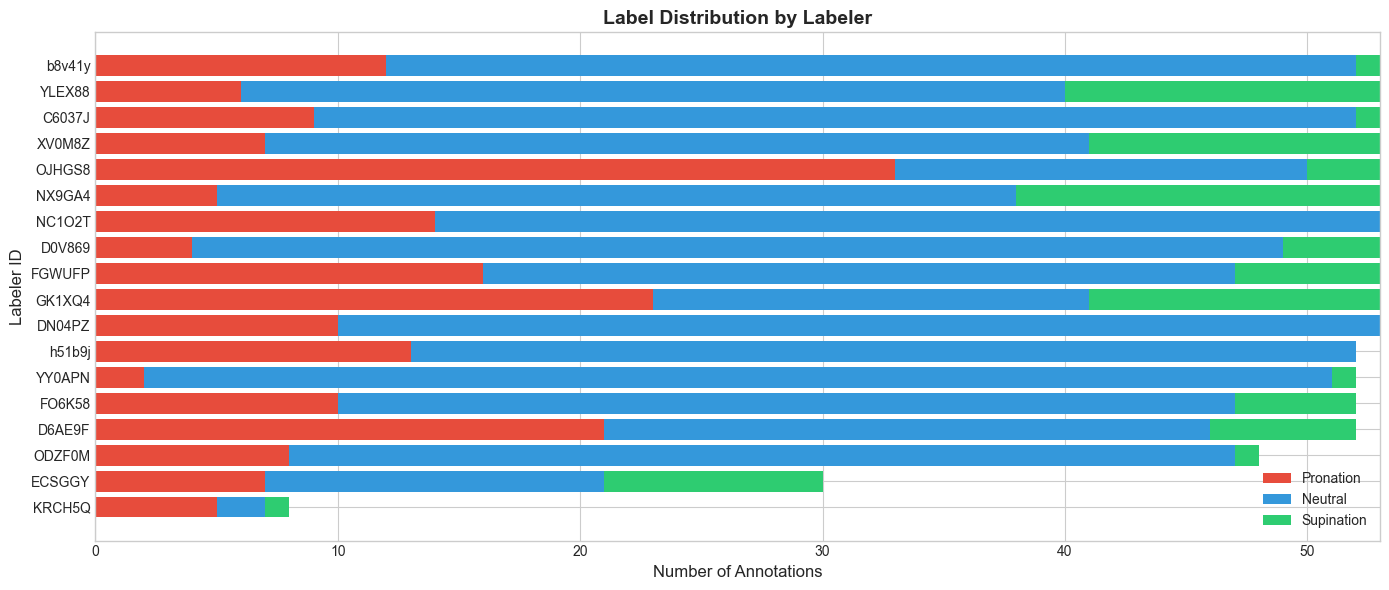

In [12]:
# Visualize per-labeler distribution as stacked bars
fig, ax = plt.subplots(figsize=(14, 6))

df_plot = df_labeler_stats.sort_values('total', ascending=True)
y_pos = range(len(df_plot))

p1 = ax.barh(y_pos, df_plot['Pronation'], 0.8, label='Pronation', color='#e74c3c')
p2 = ax.barh(y_pos, df_plot['Neutral'], 0.8, left=df_plot['Pronation'], label='Neutral', color='#3498db')
p3 = ax.barh(y_pos, df_plot['Supination'], 0.8, 
             left=df_plot['Pronation'] + df_plot['Neutral'], label='Supination', color='#2ecc71')

ax.set_yticks(y_pos)
ax.set_yticklabels(df_plot.index)
ax.set_xlabel('Number of Annotations', fontsize=12)
ax.set_ylabel('Labeler ID', fontsize=12)
ax.set_title('Label Distribution by Labeler', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()


## 4. Coverage Analysis


Image Coverage Distribution:
labeler_count
15     1
16    25
17    24
18     3
Name: count, dtype: int64


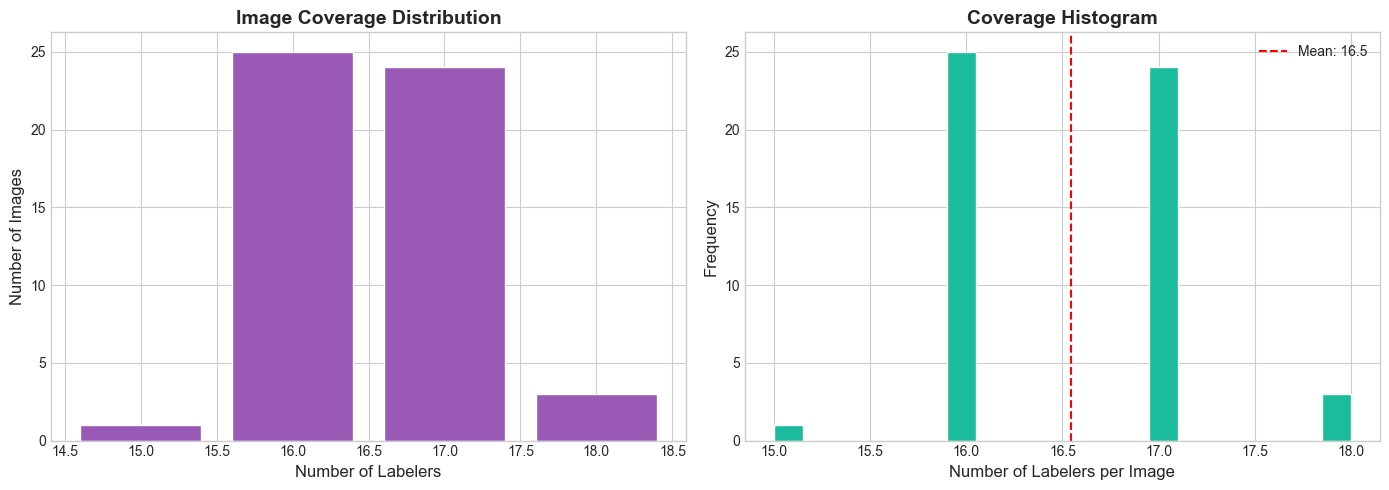


Mean coverage: 16.55 labelers per image
Max coverage: 18 labelers
Min coverage: 15 labelers


In [13]:
# Calculate coverage per image
df_labels_simple['labeler_count'] = df_labels_simple.apply(lambda row: row.dropna().count(), axis=1)

coverage_dist = df_labels_simple['labeler_count'].value_counts().sort_index()
print("Image Coverage Distribution:")
print(coverage_dist)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
ax1.bar(coverage_dist.index, coverage_dist.values, color='#9b59b6', edgecolor='white')
ax1.set_xlabel('Number of Labelers', fontsize=12)
ax1.set_ylabel('Number of Images', fontsize=12)
ax1.set_title('Image Coverage Distribution', fontsize=14, fontweight='bold')

ax2 = axes[1]
sorted_coverage = df_labels_simple['labeler_count'].sort_values(ascending=False)
ax2.hist(sorted_coverage, bins=20, color='#1abc9c', edgecolor='white')
ax2.axvline(sorted_coverage.mean(), color='red', linestyle='--', label=f'Mean: {sorted_coverage.mean():.1f}')
ax2.set_xlabel('Number of Labelers per Image', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Coverage Histogram', fontsize=14, fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"\nMean coverage: {sorted_coverage.mean():.2f} labelers per image")
print(f"Max coverage: {sorted_coverage.max()} labelers")
print(f"Min coverage: {sorted_coverage.min()} labelers")


## 5. Inter-Rater Agreement Analysis


In [14]:
# Calculate per-image agreement
df_analysis = df_labels_simple.drop(columns=['labeler_count']).copy()

def calculate_image_agreement(row):
    labels = row.dropna().tolist()
    if len(labels) == 0:
        return pd.Series({'mode_label': None, 'mode_count': 0, 'total_labels': 0, 'agreement_pct': 0})
    
    counter = Counter(labels)
    mode_label, mode_count = counter.most_common(1)[0]
    agreement_pct = mode_count / len(labels) * 100
    
    return pd.Series({
        'mode_label': mode_label, 'mode_count': mode_count,
        'total_labels': len(labels), 'agreement_pct': agreement_pct
    })

df_agreement = df_analysis.apply(calculate_image_agreement, axis=1)
df_agreement.index = df_analysis.index

print("Agreement Statistics Summary:")
print(f"  Mean agreement: {df_agreement['agreement_pct'].mean():.1f}%")
print(f"  Median agreement: {df_agreement['agreement_pct'].median():.1f}%")
print(f"  Min agreement: {df_agreement['agreement_pct'].min():.1f}%")
print(f"  Max agreement: {df_agreement['agreement_pct'].max():.1f}%")
df_agreement.head(10)


Agreement Statistics Summary:
  Mean agreement: 72.6%
  Median agreement: 75.0%
  Min agreement: 41.2%
  Max agreement: 100.0%


,mode_label,mode_count,total_labels,agreement_pct
image,,,,
sajat_resztvevo01_01.jpg,Pronation,11,16,68.75
sajat_resztvevo01_02.jpg,Pronation,12,16,75.00
sajat_resztvevo01_03.jpg,Pronation,12,16,75.00
sajat_resztvevo01_04.jpg,Pronation,12,16,75.00
sajat_resztvevo02_01.jpg,Neutral,12,16,75.00
sajat_resztvevo02_02.jpg,Neutral,11,16,68.75
sajat_resztvevo02_03.jpg,Neutral,10,16,62.50
sajat_resztvevo02_04.jpg,Neutral,15,16,93.75
sajat_resztvevo03_01.jpg,Neutral,14,16,87.50


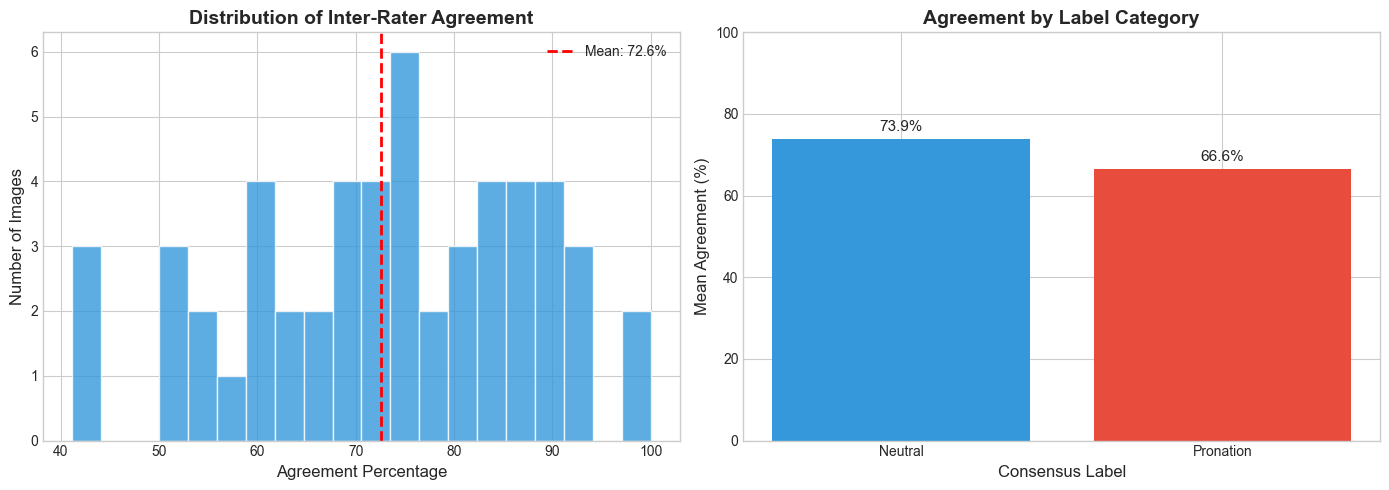

In [15]:
# Visualize agreement distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
ax1.hist(df_agreement['agreement_pct'], bins=20, color='#3498db', edgecolor='white', alpha=0.8)
ax1.axvline(df_agreement['agreement_pct'].mean(), color='red', linestyle='--', 
            linewidth=2, label=f'Mean: {df_agreement["agreement_pct"].mean():.1f}%')
ax1.set_xlabel('Agreement Percentage', fontsize=12)
ax1.set_ylabel('Number of Images', fontsize=12)
ax1.set_title('Distribution of Inter-Rater Agreement', fontsize=14, fontweight='bold')
ax1.legend()

ax2 = axes[1]
agreement_by_label = df_agreement.groupby('mode_label')['agreement_pct'].mean()
colors = {'Pronation': '#e74c3c', 'Neutral': '#3498db', 'Supination': '#2ecc71'}
bars = ax2.bar(agreement_by_label.index, agreement_by_label.values,
               color=[colors.get(x, '#95a5a6') for x in agreement_by_label.index])
ax2.set_xlabel('Consensus Label', fontsize=12)
ax2.set_ylabel('Mean Agreement (%)', fontsize=12)
ax2.set_title('Agreement by Label Category', fontsize=14, fontweight='bold')
ax2.set_ylim(0, 100)
for bar, val in zip(bars, agreement_by_label.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, f'{val:.1f}%', ha='center', fontsize=11)

plt.tight_layout()
plt.show()


## 6. Disputed Images Analysis


In [16]:
# Find images with lowest agreement
df_disputed = df_agreement[df_agreement['total_labels'] >= 2].copy()
df_disputed = df_disputed.sort_values('agreement_pct', ascending=True)

print("Top 15 Most Disputed Images (lowest agreement):")
print("=" * 70)
for idx, row in df_disputed.head(15).iterrows():
    print(f"\n{idx}")
    print(f"  Consensus: {row['mode_label']} ({int(row['mode_count'])}/{int(row['total_labels'])} labelers)")
    print(f"  Agreement: {row['agreement_pct']:.1f}%")
    img_labels = df_analysis.loc[idx].dropna().tolist()
    print(f"  Label distribution: {dict(Counter(img_labels))}")


Top 15 Most Disputed Images (lowest agreement):

sajat_reszvevo_05_03.jpg
  Consensus: Neutral (7/17 labelers)
  Agreement: 41.2%
  Label distribution: {'Neutral': 7, 'Pronation': 4, 'Supination': 6}

sajat_reszvevo_05_01.jpg
  Consensus: Neutral (7/17 labelers)
  Agreement: 41.2%
  Label distribution: {'Neutral': 7, 'Pronation': 5, 'Supination': 5}

sajat_reszvevo_05_02.jpg
  Consensus: Neutral (7/17 labelers)
  Agreement: 41.2%
  Label distribution: {'Neutral': 7, 'Pronation': 5, 'Supination': 5}

sajat_resztvevo04_04.jpg
  Consensus: Neutral (8/16 labelers)
  Agreement: 50.0%
  Label distribution: {'Pronation': 7, 'Neutral': 8, 'Supination': 1}

sajat_reszvevo03_03.jpg
  Consensus: Neutral (8/16 labelers)
  Agreement: 50.0%
  Label distribution: {'Neutral': 8, 'Supination': 4, 'Pronation': 4}

sajat_resztvevo04_03.jpg
  Consensus: Pronation (8/16 labelers)
  Agreement: 50.0%
  Label distribution: {'Pronation': 8, 'Neutral': 7, 'Supination': 1}

sajat_reszvevo_05_05.jpg
  Consensus: 

## 7. Labeler Agreement Heatmap


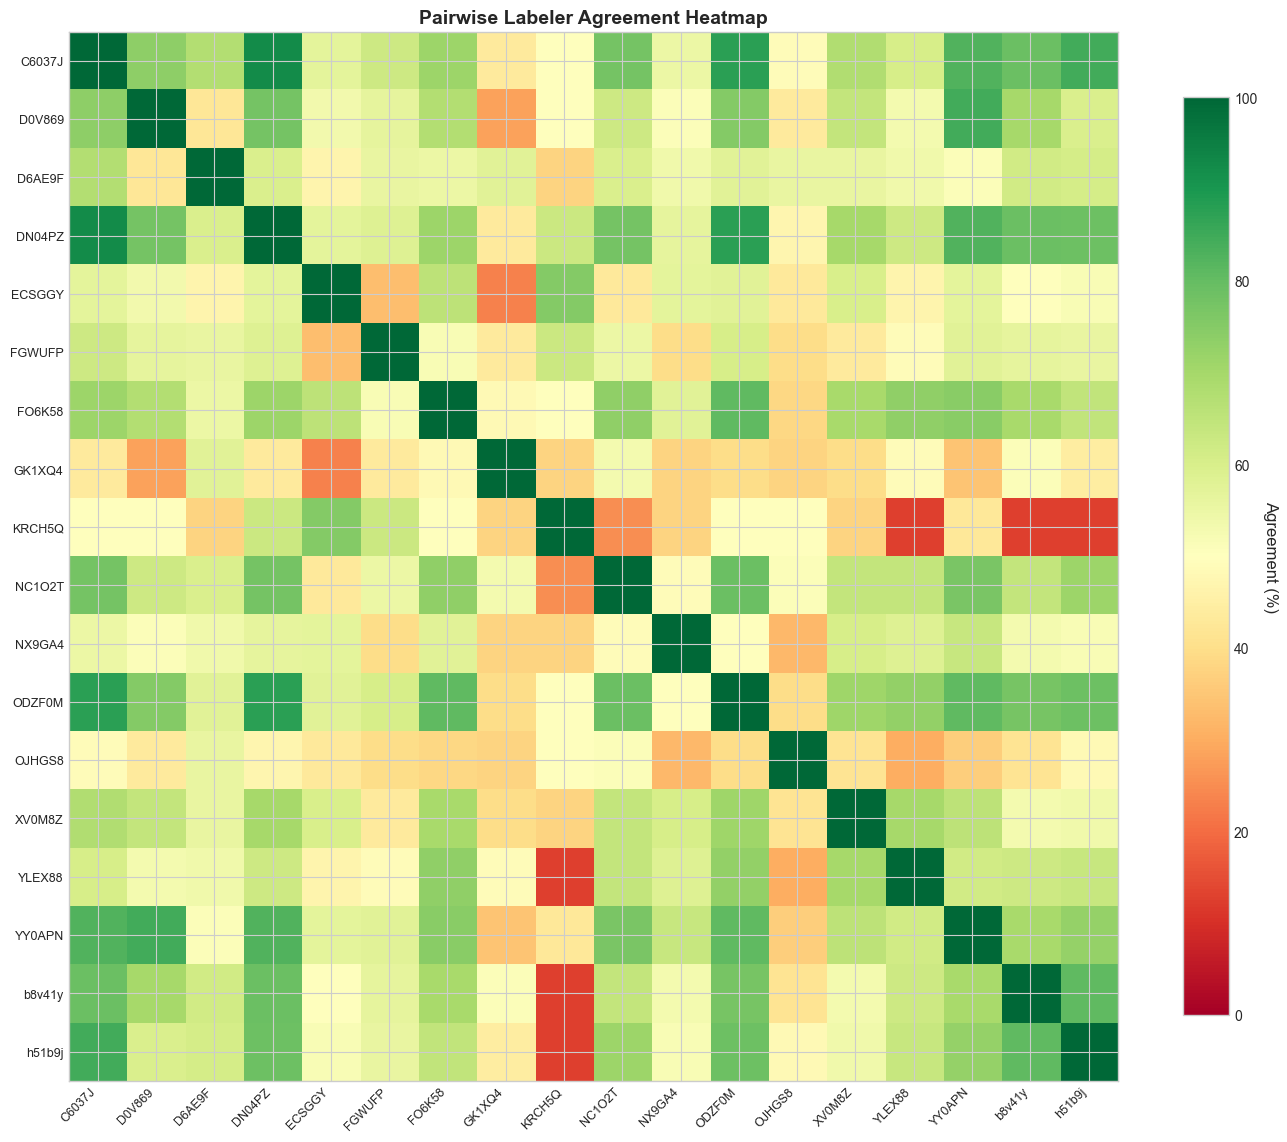


Pairwise Agreement Statistics:
  Mean: 56.8%
  Median: 56.7%
  Min: 12.5%, Max: 92.5%


In [17]:
# Calculate pairwise agreement between labelers
labelers = df_analysis.columns.tolist()
n_labelers = len(labelers)
agreement_matrix = np.zeros((n_labelers, n_labelers))

for i, lab1 in enumerate(labelers):
    for j, lab2 in enumerate(labelers):
        if i == j:
            agreement_matrix[i, j] = 100.0
        else:
            mask = df_analysis[lab1].notna() & df_analysis[lab2].notna()
            if mask.sum() > 0:
                agree = (df_analysis.loc[mask, lab1] == df_analysis.loc[mask, lab2]).sum()
                agreement_matrix[i, j] = agree / mask.sum() * 100

fig, ax = plt.subplots(figsize=(14, 12))
im = ax.imshow(agreement_matrix, cmap='RdYlGn', vmin=0, vmax=100)

ax.set_xticks(range(n_labelers))
ax.set_yticks(range(n_labelers))
ax.set_xticklabels(labelers, rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(labelers, fontsize=9)

cbar = ax.figure.colorbar(im, ax=ax, shrink=0.8)
cbar.ax.set_ylabel('Agreement (%)', rotation=-90, va="bottom", fontsize=12)
ax.set_title('Pairwise Labeler Agreement Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

mask = ~np.eye(n_labelers, dtype=bool)
pairwise_values = agreement_matrix[mask]
print(f"\nPairwise Agreement Statistics:")
print(f"  Mean: {np.mean(pairwise_values):.1f}%")
print(f"  Median: {np.median(pairwise_values):.1f}%")
print(f"  Min: {np.min(pairwise_values):.1f}%, Max: {np.max(pairwise_values):.1f}%")


## 8. Labeler Quality Ranking

Calculate metrics to rank labelers by reliability and agreement with consensus.


In [18]:
# Calculate labeler quality metrics
labeler_metrics = []

for labeler_id in df_analysis.columns:
    labeler_labels = df_analysis[labeler_id]
    labeled_mask = labeler_labels.notna()
    n_labeled = labeled_mask.sum()
    
    if n_labeled == 0:
        continue
    
    # 1. Agreement with consensus (mode label)
    consensus_agreement = 0
    for img_name in df_analysis.index[labeled_mask]:
        if labeler_labels[img_name] == df_agreement.loc[img_name, 'mode_label']:
            consensus_agreement += 1
    consensus_agreement_pct = consensus_agreement / n_labeled * 100
    
    # 2. Average pairwise agreement with other labelers
    pairwise_agreements = []
    labeler_idx = labelers.index(labeler_id)
    for other_idx, other_id in enumerate(labelers):
        if other_idx != labeler_idx:
            pairwise_agreements.append(agreement_matrix[labeler_idx, other_idx])
    avg_pairwise = np.mean([p for p in pairwise_agreements if p > 0]) if pairwise_agreements else 0
    
    # 3. Agreement on "easy" images (images where >80% of labelers agree)
    easy_images = df_agreement[df_agreement['agreement_pct'] >= 80].index
    easy_labeled = labeler_labels[easy_images].dropna()
    easy_correct = sum(1 for img in easy_labeled.index 
                      if labeler_labels[img] == df_agreement.loc[img, 'mode_label'])
    easy_agreement_pct = (easy_correct / len(easy_labeled) * 100) if len(easy_labeled) > 0 else 0
    
    # 4. Coverage (% of consensus images labeled)
    coverage_pct = n_labeled / len(valid_image_names) * 100
    
    # 5. Label diversity (entropy-like measure - are they using all categories?)
    label_counts = labeler_labels.dropna().value_counts(normalize=True)
    if len(label_counts) > 1:
        entropy = -sum(p * np.log2(p) for p in label_counts if p > 0)
        max_entropy = np.log2(3)  # 3 categories
        diversity = entropy / max_entropy * 100
    else:
        diversity = 0
    
    labeler_metrics.append({
        'labeler_id': labeler_id,
        'n_labeled': n_labeled,
        'coverage_%': round(coverage_pct, 1),
        'consensus_agreement_%': round(consensus_agreement_pct, 1),
        'avg_pairwise_agreement_%': round(avg_pairwise, 1),
        'easy_image_agreement_%': round(easy_agreement_pct, 1),
        'label_diversity_%': round(diversity, 1)
    })

df_metrics = pd.DataFrame(labeler_metrics).set_index('labeler_id')
print(f"Labeler Quality Metrics ({len(df_metrics)} labelers):")
df_metrics


Labeler Quality Metrics (18 labelers):


,n_labeled,coverage_%,consensus_agreement_%,avg_pairwise_agreement_%,easy_image_agreement_%,label_diversity_%
labeler_id,,,,,,
C6037J,53,100.0,94.3,68.3,100.0,49.7
D0V869,53,100.0,75.5,59.5,100.0,48.1
D6AE9F,52,98.1,65.4,54.8,84.2,88.1
DN04PZ,53,100.0,94.3,68.4,100.0,44.1
ECSGGY,30,56.6,60.0,51.6,69.2,96.2
FGWUFP,53,100.0,64.2,51.8,80.0,83.9
FO6K58,52,98.1,76.9,63.6,100.0,71.4
GK1XQ4,53,100.0,43.4,41.8,50.0,97.0
KRCH5Q,8,15.1,50.0,41.5,0.0,81.9


In [19]:
# Calculate composite quality score and rank labelers
# Weights for different metrics (can be adjusted)
weights = {
    'consensus_agreement_%': 0.35,      # Most important - agrees with majority
    'avg_pairwise_agreement_%': 0.25,   # Important - consistent with peers
    'easy_image_agreement_%': 0.25,     # Important - gets "easy" cases right
    'coverage_%': 0.10,                 # Less important but shows engagement
    'label_diversity_%': 0.05           # Minor - using all categories
}

# Normalize each metric to 0-100 scale and calculate weighted score
df_ranking = df_metrics.copy()

for metric, weight in weights.items():
    # Min-max normalization
    min_val = df_ranking[metric].min()
    max_val = df_ranking[metric].max()
    if max_val > min_val:
        df_ranking[f'{metric}_norm'] = (df_ranking[metric] - min_val) / (max_val - min_val) * 100
    else:
        df_ranking[f'{metric}_norm'] = 100

# Calculate composite score
df_ranking['quality_score'] = sum(
    df_ranking[f'{metric}_norm'] * weight 
    for metric, weight in weights.items()
)

# Rank labelers
df_ranking['rank'] = df_ranking['quality_score'].rank(ascending=False).astype(int)
df_ranking = df_ranking.sort_values('quality_score', ascending=False)

# Display ranking
print("=" * 70)
print("LABELER QUALITY RANKING")
print("=" * 70)
print("\nScore Weights:")
for metric, weight in weights.items():
    print(f"  {metric}: {weight*100:.0f}%")

print("\n" + "=" * 70)
df_ranking[['rank', 'quality_score', 'n_labeled', 'consensus_agreement_%', 
            'avg_pairwise_agreement_%', 'easy_image_agreement_%']].round(1)


LABELER QUALITY RANKING

Score Weights:
  consensus_agreement_%: 35%
  avg_pairwise_agreement_%: 25%
  easy_image_agreement_%: 25%
  coverage_%: 10%
  label_diversity_%: 5%



,rank,quality_score,n_labeled,consensus_agreement_%,avg_pairwise_agreement_%,easy_image_agreement_%
labeler_id,,,,,,
C6037J,1,96.7,53,94.3,68.3,100.0
DN04PZ,2,96.4,53,94.3,68.4,100.0
ODZF0M,3,93.0,48,93.8,67.4,94.4
YY0APN,4,84.3,52,84.6,64.3,100.0
FO6K58,5,81.6,52,76.9,63.6,100.0
h51b9j,6,81.6,52,84.6,60.8,94.7
b8v41y,7,79.7,53,81.1,60.6,95.0
NC1O2T,8,77.7,53,79.2,61.5,90.0
D0V869,9,75.5,53,75.5,59.5,100.0


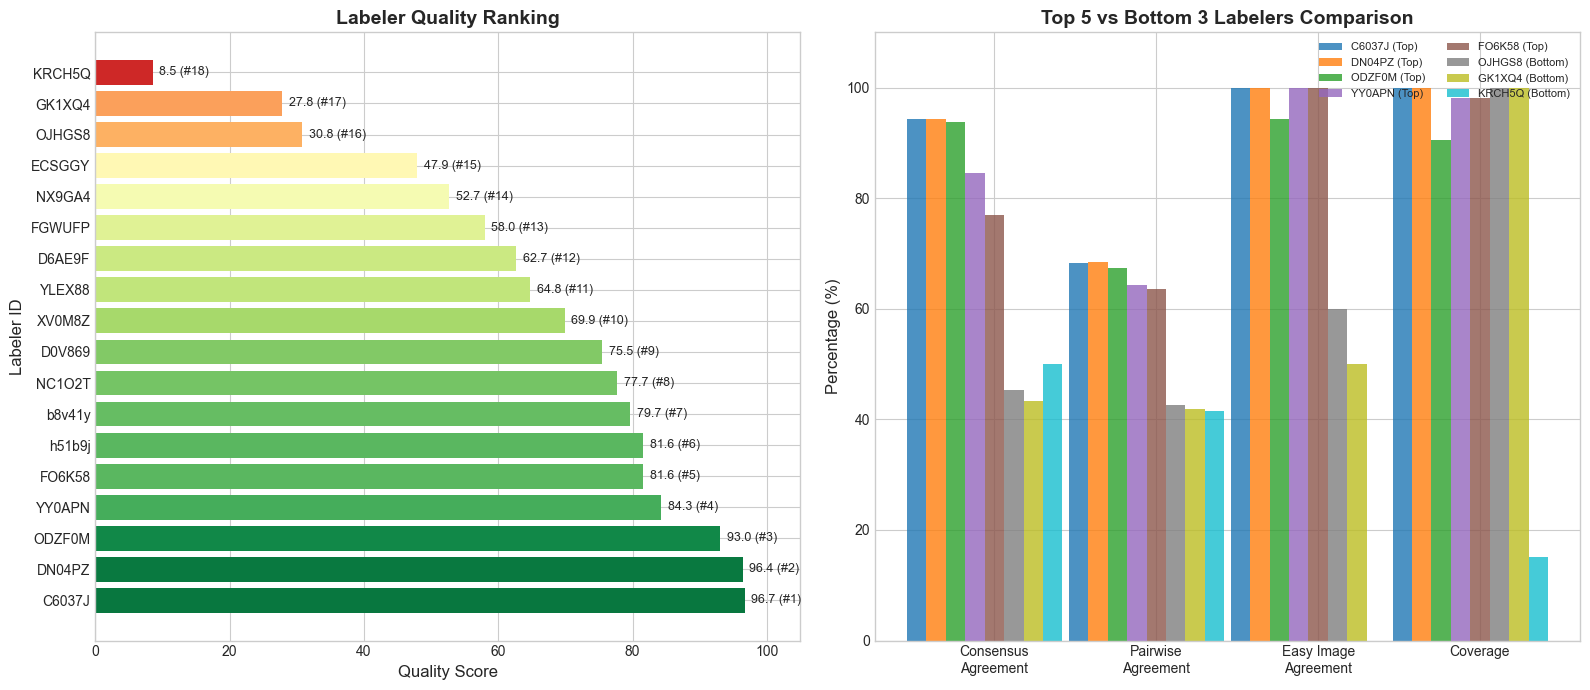

In [20]:
# Visualize labeler ranking
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Bar chart of quality scores
ax1 = axes[0]
colors_rank = plt.cm.RdYlGn(df_ranking['quality_score'] / 100)
bars = ax1.barh(range(len(df_ranking)), df_ranking['quality_score'], color=colors_rank)
ax1.set_yticks(range(len(df_ranking)))
ax1.set_yticklabels(df_ranking.index)
ax1.set_xlabel('Quality Score', fontsize=12)
ax1.set_ylabel('Labeler ID', fontsize=12)
ax1.set_title('Labeler Quality Ranking', fontsize=14, fontweight='bold')
ax1.set_xlim(0, 105)

# Add score labels
for i, (score, rank) in enumerate(zip(df_ranking['quality_score'], df_ranking['rank'])):
    ax1.text(score + 1, i, f'{score:.1f} (#{rank})', va='center', fontsize=9)

# Radar chart for top 5 labelers
ax2 = axes[1]
metrics_to_plot = ['consensus_agreement_%', 'avg_pairwise_agreement_%', 
                   'easy_image_agreement_%', 'coverage_%']
labels_short = ['Consensus\nAgreement', 'Pairwise\nAgreement', 'Easy Image\nAgreement', 'Coverage']

top_labelers = df_ranking.head(5).index.tolist()
bottom_labelers = df_ranking.tail(3).index.tolist()

# Simple grouped bar for comparison
x = np.arange(len(metrics_to_plot))
width = 0.12
colors_bar = plt.cm.tab10(np.linspace(0, 1, len(top_labelers) + len(bottom_labelers)))

for i, labeler in enumerate(top_labelers + bottom_labelers):
    values = [df_ranking.loc[labeler, m] for m in metrics_to_plot]
    offset = (i - (len(top_labelers) + len(bottom_labelers)) / 2) * width
    marker = 'Top' if labeler in top_labelers else 'Bottom'
    ax2.bar(x + offset, values, width, label=f'{labeler} ({marker})', 
            color=colors_bar[i], alpha=0.8)

ax2.set_xticks(x)
ax2.set_xticklabels(labels_short, fontsize=10)
ax2.set_ylabel('Percentage (%)', fontsize=12)
ax2.set_title('Top 5 vs Bottom 3 Labelers Comparison', fontsize=14, fontweight='bold')
ax2.legend(loc='upper right', fontsize=8, ncol=2)
ax2.set_ylim(0, 110)

plt.tight_layout()
plt.show()


In [21]:
# Identify labelers that may need attention
print("=" * 70)
print("LABELER QUALITY SUMMARY")
print("=" * 70)

# Top performers
print("\n🏆 TOP 5 LABELERS (Most Reliable):")
for i, (labeler_id, row) in enumerate(df_ranking.head(5).iterrows(), 1):
    print(f"  {i}. {labeler_id}: Score {row['quality_score']:.1f} | "
          f"Consensus: {row['consensus_agreement_%']:.0f}% | "
          f"Labeled: {row['n_labeled']} images")

# Low performers (potential review needed)
threshold = df_ranking['quality_score'].quantile(0.25)
low_performers = df_ranking[df_ranking['quality_score'] < threshold]

print(f"\n⚠️ LABELERS BELOW 25TH PERCENTILE (Score < {threshold:.1f}):")
if len(low_performers) > 0:
    for labeler_id, row in low_performers.iterrows():
        issues = []
        if row['consensus_agreement_%'] < 70:
            issues.append(f"low consensus ({row['consensus_agreement_%']:.0f}%)")
        if row['easy_image_agreement_%'] < 80:
            issues.append(f"misses easy cases ({row['easy_image_agreement_%']:.0f}%)")
        if row['n_labeled'] < 20:
            issues.append(f"low coverage ({row['n_labeled']} images)")
        
        print(f"  - {labeler_id}: Score {row['quality_score']:.1f}")
        if issues:
            print(f"    Issues: {', '.join(issues)}")
else:
    print("  None - all labelers above threshold!")

# Overall statistics
print(f"\n📊 OVERALL STATISTICS:")
print(f"  Mean quality score: {df_ranking['quality_score'].mean():.1f}")
print(f"  Median quality score: {df_ranking['quality_score'].median():.1f}")
print(f"  Score range: {df_ranking['quality_score'].min():.1f} - {df_ranking['quality_score'].max():.1f}")
print(f"  Mean consensus agreement: {df_ranking['consensus_agreement_%'].mean():.1f}%")


LABELER QUALITY SUMMARY

🏆 TOP 5 LABELERS (Most Reliable):
  1. C6037J: Score 96.7 | Consensus: 94% | Labeled: 53.0 images
  2. DN04PZ: Score 96.4 | Consensus: 94% | Labeled: 53.0 images
  3. ODZF0M: Score 93.0 | Consensus: 94% | Labeled: 48.0 images
  4. YY0APN: Score 84.3 | Consensus: 85% | Labeled: 52.0 images
  5. FO6K58: Score 81.6 | Consensus: 77% | Labeled: 52.0 images

⚠️ LABELERS BELOW 25TH PERCENTILE (Score < 54.0):
  - NX9GA4: Score 52.7
    Issues: low consensus (55%)
  - ECSGGY: Score 47.9
    Issues: low consensus (60%), misses easy cases (69%)
  - OJHGS8: Score 30.8
    Issues: low consensus (45%), misses easy cases (60%)
  - GK1XQ4: Score 27.8
    Issues: low consensus (43%), misses easy cases (50%)
  - KRCH5Q: Score 8.5
    Issues: low consensus (50%), misses easy cases (0%), low coverage (8.0 images)

📊 OVERALL STATISTICS:
  Mean quality score: 66.1
  Median quality score: 72.7
  Score range: 8.5 - 96.7
  Mean consensus agreement: 71.3%


In [22]:
# Export all analysis results to CSV
output_path = Path("../data/labeler_analysis_exports")
output_path.mkdir(exist_ok=True)

# Export labeler ranking
df_ranking_export = df_ranking[['rank', 'quality_score', 'n_labeled', 
                                 'consensus_agreement_%', 'avg_pairwise_agreement_%',
                                 'easy_image_agreement_%', 'coverage_%', 'label_diversity_%']]
df_ranking_export.to_csv(output_path / "labeler_ranking.csv")

# Export consensus labels
df_consensus = df_agreement[['mode_label', 'mode_count', 'total_labels', 'agreement_pct']].copy()
df_consensus.columns = ['consensus_label', 'votes', 'total_labelers', 'agreement_pct']
df_consensus['original_path'] = df_consensus.index.map(lambda x: image_name_to_path.get(x, None))
df_consensus.to_csv(output_path / "consensus_labels.csv")

# Export full labels matrix
df_labels_simple.to_csv(output_path / "all_labels_matrix.csv")

# Export labeler statistics  
df_labeler_stats.to_csv(output_path / "labeler_statistics.csv")

print(f"Exported files to {output_path.absolute()}:")
print(f"  - labeler_ranking.csv (quality scores and ranks)")
print(f"  - consensus_labels.csv (consensus summary)")
print(f"  - all_labels_matrix.csv (full label matrix)")
print(f"  - labeler_statistics.csv (per-labeler stats)")


Exported files to d:\src\repos\ankle-align\notebook\..\data\labeler_analysis_exports:
  - labeler_ranking.csv (quality scores and ranks)
  - consensus_labels.csv (consensus summary)
  - all_labels_matrix.csv (full label matrix)
  - labeler_statistics.csv (per-labeler stats)
